In [1]:
import datetime
import scipy as scp
from ribbonv2 import *
from samplingv4 import *
from plotResult_v2 import *
import numpy as np
import sklearn.metrics 
import pickle

import warnings

In [2]:
"""
load data
"""

filename = '../data/cell1.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    
stim_binary = f['stim_binary'][:]
stim_gauss = f['stim_gauss'][:]

r_binary = f['r_binary'][:]
r_gauss = f['r_gauss'][:]

f.close()


# choose data
light = stim_binary
data = r_binary

# stim time with time resolution of dt =1ms
stimT = np.arange(0, len(light),1)/1000


dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 4 recordings per stim, binned sum for r but raw for stim (dt=1)


### produce data summary stats

In [3]:
"""
specify summary stats

for n>1
"""

#data=data[1:]

nSS = 9


## specify kernel to compare traces
g = scipy.signal.gaussian(10,2)

  




# number of recorded traces
nTrue = len(data)

lenData = len(data[0])
trueG = np.zeros((nTrue,lenData+len(g)-1))

for i in range(nTrue):
    trueG[i,:] = scipy.signal.convolve(data[i],g)
  

# specify weights for summary stats
unweighted_data_SS = makeSS(data,g,trueG, w = np.ones(nSS))
# normalizing factor
w_norm = 1/unweighted_data_SS
w_norm[np.isinf(w_norm)] = 1/48 #(1/48 mean value for the recorded traces)
#scaling factor for each sums stat
w_scale =  np.ones(len(unweighted_data_SS))
w_scale[0] = 5 # conv
w_scale[1] = 5 # sum of all
w_scale[2] = 5 # 1-fold
w_scale[3] = 5 # 2-fold
w_scale[4] = 2 # 4-fold
w_scale[5] = 2 # 5 fold
w_scale[6] = 4 # 6 fold
w_scale[7] = 2 # std

# final w 
w = w_norm * w_scale

dataSS = makeSS(data,g,trueG,w)


    
    
    
 

# fitting here

In [4]:
"""
specify priors here!!!
also: dock and ribbon size
"""

dockMax = 7
ribbonMax = 50

def makeHypersPrior():
    """
    :return: hyper parameters for the ribbon prior distributions
    """
    k_x0Hypers = [np.array([20, 0.5]), np.eye(2) * np.array([400, 0.1]), 4, 4]  # [mu0s,Lambda0, kappa0, nu0]
    dPHypers = [0.3, 0.05, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]
    rlHypers = [2, 0.25]  # [k, scale(theta)] # mean=k*theta
    rhoHypers = [0.5, 0.05, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]
    
    kernelscaleHypers = [1, 0.2, 3, 3]  # [mu0, sigma0sq, kappa0, nu0]

    
    hypers = [k_x0Hypers, dPHypers, rlHypers, rhoHypers, kernelscaleHypers]
    return hypers






In [5]:
# specify stimulus

def run_parallel_ribbon(*parameters):
    sampsParams = np.array(parameters)
    outUn =  runManyRibbon(light, g,trueG,dataSS, sampsParams, batchsize, w, stim_kind='light')
    return outUn

In [6]:
## number of samples
# if nr is to small error araises from taking best 1000 values etc.
nSamps0 = 40000
nSampsLate =20000
nsave = 1000

# number of sample to update from
nupdate0 = 10 # 20
nupdate_late = 10 # 20
importance_factor0 = 1#0.2
importance_factor_late = 1#0.2


batchsize = 4

"""
switching fitting
"""

# choose nr of processes working in parallel
pr = 25

# number of runs
runs = 100


# arrays for saving results 
# best nsave are saved
outRSave = np.zeros((runs,9,nsave))
hypersSave = []#np.zeros((runs,5,2))


# prior parameters for ribbon params
cHyper = [0,0,0,0,1,1,0,0] # 1 if constant, 0 else
c2 = [0,0,0,0,dockMax,ribbonMax,0,0]
constants = np.stack((cHyper,c2))  

#hypers = hypers_old[-1]
hypers = makeHypersPrior() # not used for uniform priors
hypersSave.append(hypers)

for noRun in range(0,runs):
    if noRun ==0:
        nSamps = nSamps0
        nupdate = nupdate0
        importance_factor = importance_factor0
    else:
        nSamps = nSampsLate
        nupdate = nupdate_late
        importance_factor = importance_factor_late
    print()
    print('run',noRun)
    
    
    """
    run for params
    """

    # sample params 
    sampsStackR = list([])


    for j in range(0,pr):
        sampsStackR.append(drawSamps(constants,hypers,int(nSamps/pr)))
    
    print('finished sampling, now run simulations...')

    with multiprocessing.Pool(processes=pr) as pool:
        outUnStackR = pool.starmap(run_parallel_ribbon, sampsStackR)

    #temp3 = datetime.datetime.now()
    #tempdiff = temp3 - temp2
    #print('time used for ribbon fitting',tempdiff)


    #reshape and sort results
    outUnStackR = np.array(outUnStackR)
    outUnR = np.zeros((9,np.shape(outUnStackR)[0]*np.shape(outUnStackR)[2]))
    #outUn = np.zeros((6,np.shape(outUnStack)[0]*np.shape(outUnStack)[2]))

    for i in range(0, np.shape(outUnStackR)[0]):
        outUnR[:,i*np.shape(outUnStackR)[2]:i*np.shape(outUnStackR)[2]+np.shape(outUnStackR)[2]] = outUnStackR[i,:,:]

    # sorting:
    outR = outUnR[:,outUnR[-1,:].argsort()]

    # update parameters
    # using mean of best threshold samples 
    threshold = nupdate 
    params = np.mean(outR[:-1,:threshold], axis=1)
    print('paramsmean =',params)
    
    #pairPlotStuff_truevalues(outR[0,:100],outR[1,:100],outR[3,:100],outR[2,:100], trueK,
     #                   trueX0, trueRibbonLambda,trueDockP, markersize=30)
    
    """
    Prior updating for params
    """
    # for params
    hypers = makeHypers(hypers, outR, nupdate_raw=nupdate, importance_factor=importance_factor) 
    
    print('updated hypers', hypers)    
    
    hypersSave.append(hypers)
    outRSave[noRun,:,:] = outR[:,:nsave]
    
# save data

filename = "save_data_test.pkl"


metaInfo = 'batchsize: {}, nSamps0: {}, nSampsLate: {}, nupdate0: {}, nupdate_late: {}, w_scale: {}, runs: {}\
            '.format(batchsize,nSamps0, nSampsLate, nupdate0, nupdate_late, w_scale, runs)

dict_data = dict({'hypers': hypersSave, 'samples': outRSave, 'metaInfo': metaInfo})
with open(filename, "wb") as f:
    pickle.dump(dict_data, f)





run 0
finished sampling, now run simulations...
paramsmean = [26.24197762  1.03631221  0.29860718  0.31160837  7.         50.
  0.33880023  0.89955518]
updated hypers [[array([24.45855544,  0.88308015]), array([[1307.80927172,    3.58950769],
       [   3.58950769,    1.5335044 ]]), 14, 14], [0.29892859699520696, 0.03932345075440902, 13, 13], [5.1160837323580015, 0.07142857142857142], [0.3760001788187819, 0.026058480618959462, 13, 13], [0.9227347556575164, 0.1431738145378966, 13, 13]]

run 1
finished sampling, now run simulations...
paramsmean = [29.79699947  1.0782401   0.24013224  0.48065069  7.         50.
  0.29653152  0.87716251]
updated hypers [[array([26.68290712,  0.9643968 ]), array([[1.96318792e+03, 7.87821478e+00],
       [7.87821478e+00, 1.76347212e+00]]), 24, 24], [0.27336496209423095, 0.032187814207158286, 23, 23], [9.92259059095984, 0.041666666666666664], [0.3414485869625034, 0.01727042030462066, 23, 23], [0.9029207364658465, 0.08603377011867634, 23, 23]]

run 2
finishe

In [17]:
dict_data = dict({'hypers': hypersSave, 'samples': outRSave, 'metaInfo': metaInfo})
with open(filename, "wb") as f:
    pickle.dump(dict_data, f)


### plotting time course

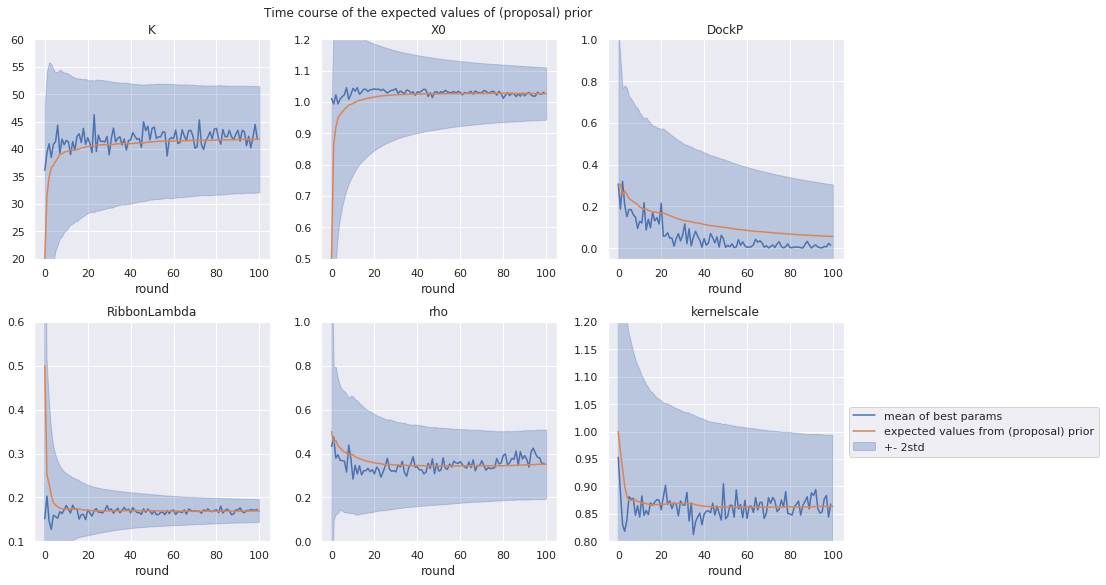

In [14]:
exp_values = get_expected_values_all(hypersSave[1:], hypersSave[0])

stds = get_stds_all(hypersSave[1:], hypersSave[0])

#trueParams = [trueK, trueX0, trueDockP, trueRibbonLambda,truerho, truescale ]
plot_time_course(outRSave, exp_values, plotTrue=False, trueParams=None, plotStds=True, stds=stds, nbest=10,
                ylimits=[[20,60],[0.5,1.2],[-0.05,1],[0.1,0.6],[0,1],[0.8,1.2]])
                # ylimits=[[10,30],[0.7,0.9],[0.2,0.9],[0.15,0.25],[0.2,0.6]])